In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import sys
sys.path.insert(0, '/home/ruizhu/Documents/Projects/semanticInverse/train')

import torch
import numpy as np
from torch.autograd import Variable
import torch.optim as optim
import argparse
import random
import os
import models
import torchvision.utils as vutils
import utils
import dataLoader
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F

parser = argparse.ArgumentParser()
# The locationi of training set
parser.add_argument('--dataRoot', default=None, help='path to input images')
parser.add_argument('--experiment', default=None, help='the path to store samples and models')
# The basic training setting
parser.add_argument('--nepoch0', type=int, default=14, help='the number of epochs for training')
parser.add_argument('--nepoch1', type=int, default=10, help='the number of epochs for training')

parser.add_argument('--batchSize0', type=int, default=16, help='input batch size')
parser.add_argument('--batchSize1', type=int, default=16, help='input batch size')

parser.add_argument('--imHeight0', type=int, default=240, help='the height / width of the input image to network')
parser.add_argument('--imWidth0', type=int, default=320, help='the height / width of the input image to network')
parser.add_argument('--imHeight1', type=int, default=240, help='the height / width of the input image to network')
parser.add_argument('--imWidth1', type=int, default=320, help='the height / width of the input image to network')

parser.add_argument('--cuda', action='store_true', help='enables cuda')
parser.add_argument('--deviceIds', type=int, nargs='+', default=[0, 1, 2], help='the gpus used for training network')
# Fine tune the network
parser.add_argument('--isFineTune', action='store_true', help='fine-tune the network')
parser.add_argument('--epochIdFineTune', type=int, default = 0, help='the training of epoch of the loaded model')
# The training weight
parser.add_argument('--albedoWeight', type=float, default=1.5, help='the weight for the diffuse component')
parser.add_argument('--normalWeight', type=float, default=1.0, help='the weight for the diffuse component')
parser.add_argument('--roughWeight', type=float, default=0.5, help='the weight for the roughness component')
parser.add_argument('--depthWeight', type=float, default=0.5, help='the weight for depth component')

# Cascae Level
parser.add_argument('--cascadeLevel', type=int, default=0, help='the casacade level')

# The detail network setting
opt = parser.parse_args('--cuda --dataRoot ../data/mini --batchSize0 1 --imHeight0 240 --imWidth0 320 --cascadeLevel 0 --experiment train_BRDF --deviceIds 0 1 2 3'.split())
print(opt)

Namespace(albedoWeight=1.5, batchSize0=1, batchSize1=16, cascadeLevel=0, cuda=True, dataRoot='../data/mini', depthWeight=0.5, deviceIds=[0, 1, 2, 3], epochIdFineTune=0, experiment='train_BRDF', imHeight0=240, imHeight1=240, imWidth0=320, imWidth1=320, isFineTune=False, nepoch0=14, nepoch1=10, normalWeight=1.0, roughWeight=0.5)


In [2]:
opt.gpuId = opt.deviceIds[0]

albeW, normW = opt.albedoWeight, opt.normalWeight
rougW = opt.roughWeight
deptW = opt.depthWeight

if opt.cascadeLevel == 0:
    opt.nepoch = opt.nepoch0
    opt.batchSize = opt.batchSize0
    opt.imHeight, opt.imWidth = opt.imHeight0, opt.imWidth0
elif opt.cascadeLevel == 1:
    opt.nepoch = opt.nepoch1
    opt.batchSize = opt.batchSize1
    opt.imHeight, opt.imWidth = opt.imHeight1, opt.imWidth1

if opt.experiment is None:
    opt.experiment = 'check_cascade%d_w%d_h%d' % (opt.cascadeLevel,
            opt.imWidth, opt.imHeight )
os.system('mkdir {0}'.format(opt.experiment) )
os.system('cp *.py %s' % opt.experiment )

opt.seed = 0
print("Random Seed: ", opt.seed )
random.seed(opt.seed )
torch.manual_seed(opt.seed )

if torch.cuda.is_available() and not opt.cuda:
    print("WARNING: You have a CUDA device, so you should probably run with --cuda")



####################################
brdfDataset = dataLoader.BatchLoader( opt.dataRoot,
        imWidth = opt.imWidth, imHeight = opt.imHeight,
        cascadeLevel = opt.cascadeLevel )
brdfLoader = DataLoader(brdfDataset, batch_size = opt.batchSize,
        num_workers = 0, shuffle = False )

Random Seed:  0
Shape Num: 6
Image Num: 198


In [3]:
from tqdm import tqdm
for i, dataBatch in tqdm(enumerate(brdfLoader)):
    print(i)
    break
    
#     print(dataBatch)
#     break

0it [00:00, ?it/s]

0


In [4]:
dataBatch.keys()

dict_keys(['albedo', 'normal', 'rough', 'depth', 'matMask', 'matMaskPath', 'segArea', 'segEnv', 'segObj', 'im', 'name'])

In [5]:
dataBatch['name'], dataBatch['matMaskPath']

(['../data/mini/mainDiffMat_xml/scene0024_00/im_33.hdr'],
 ['../data/mini/mainDiffMat_xml/scene0024_00/immatPart_33.dat'])

In [ ]:
objMask.shape

3300 1 842.3902256944444 int32 (240, 320, 3)


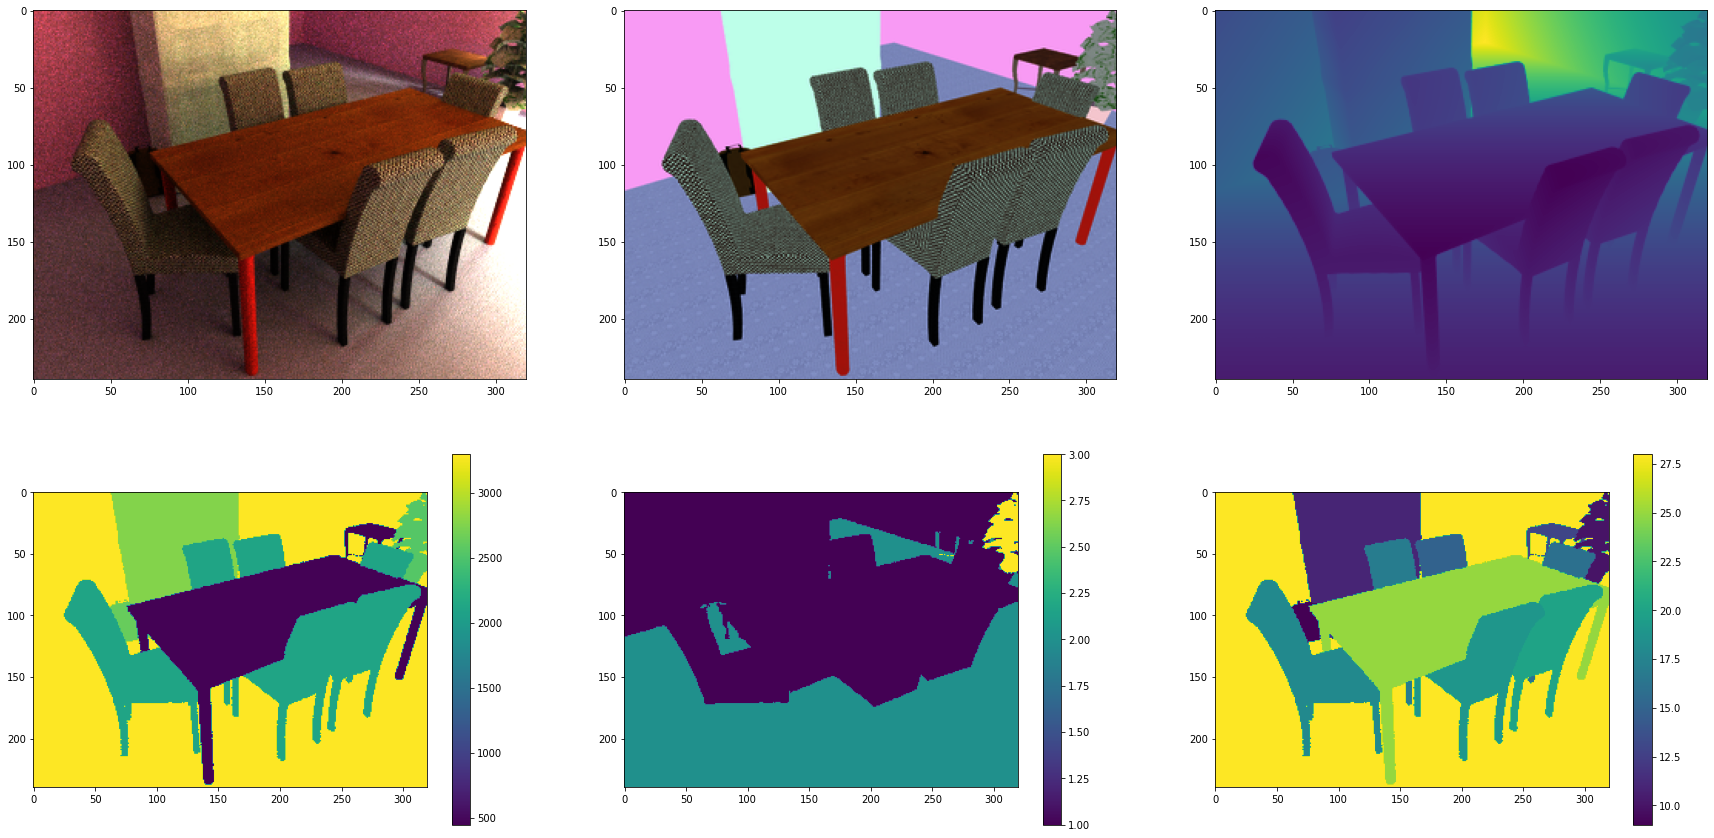

In [6]:
# mask_path = '../data/mini/main_xml1/scene0024_00/imdepth_2.dat'
# mask_path = '../data/mini/main_xml1/scene0024_00/immatPart_2.dat'

import struct
def loadBinary(imName, dtype=np.float32, if_resize=True):
    with open(imName, 'rb') as fIn:
        hBuffer = fIn.read(4)
        height = struct.unpack('i', hBuffer)[0]
        wBuffer = fIn.read(4)
        width = struct.unpack('i', wBuffer)[0]
        dBuffer = fIn.read(4 * 3 * width * height )
        depth = np.asarray(struct.unpack('i' * 3 * height * width, dBuffer), dtype=np.int32)
        depth = depth.reshape([height, width, 3] )
    return depth
            
import numpy as np
im = np.transpose(dataBatch['im'][0].numpy(), (1, 2, 0))
albedo = np.transpose(dataBatch['albedo'][0].numpy(), (1, 2, 0))
depth = dataBatch['depth'][0].numpy().squeeze()
objMask = dataBatch['matMask'][0].numpy().squeeze()

# objMask = loadBinary(dataBatch['matMaskPath'][0], if_resize=False).squeeze()[:, :, 2]

print(np.amax(objMask), np.amin(objMask), np.mean(objMask), objMask.dtype, objMask.shape)

import matplotlib.pyplot as plt
plt.figure(figsize=(30, 15))
plt.subplot(231)
plt.imshow(im)
plt.subplot(232)
plt.imshow(albedo)
plt.subplot(233)
plt.imshow(depth)
plt.subplot(234)
plt.imshow(objMask[:, :, 0])
plt.colorbar()
plt.subplot(235)
plt.imshow(objMask[:, :, 1])
plt.colorbar()
plt.subplot(236)
plt.imshow(objMask[:, :, 2])
plt.colorbar()
plt.show()

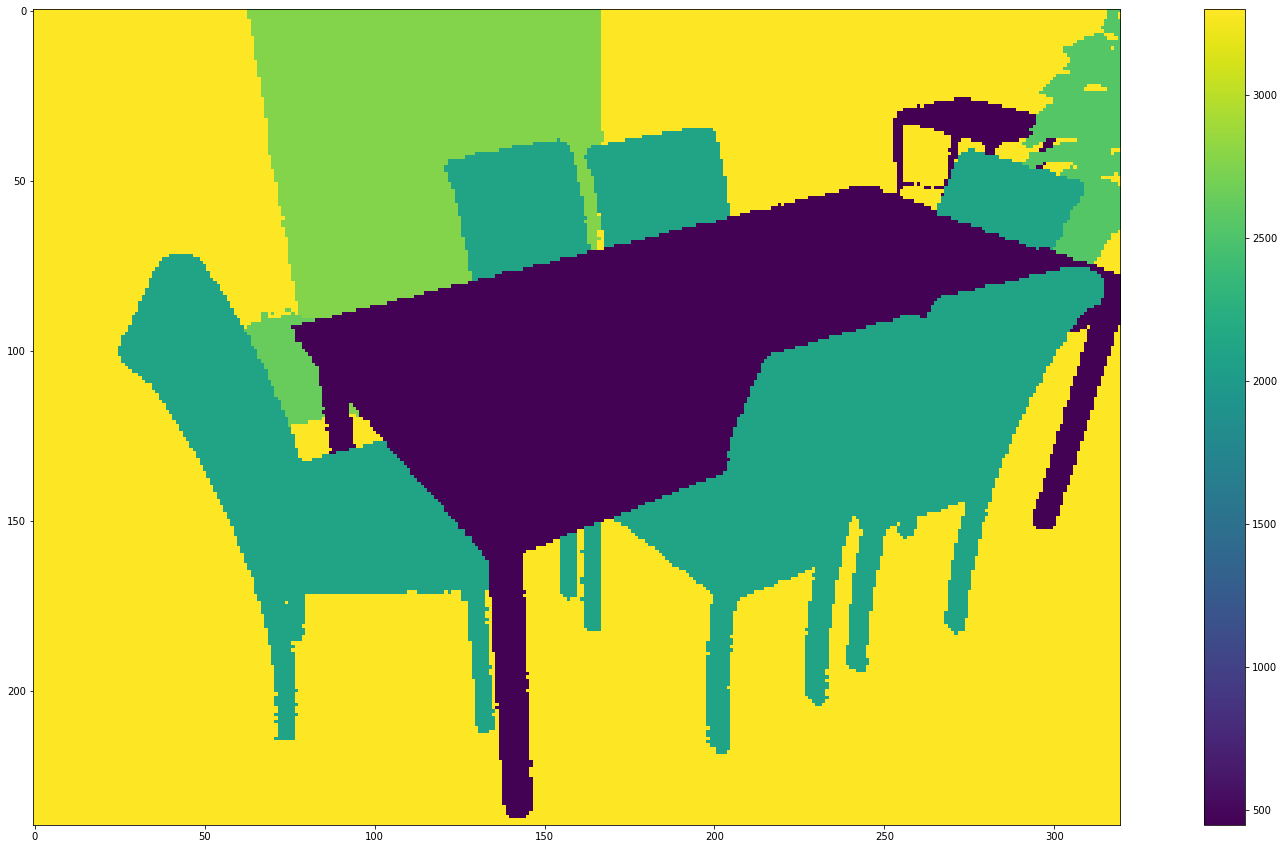

In [9]:
plt.figure(figsize=(30, 15))
plt.imshow(objMask[:, :, 0])
plt.colorbar()
plt.show()

In [12]:
a = objMask[:, :, 0]
np.unique(a)

array([ 448,  464, 2116, 2551, 2639, 2774, 3300], dtype=int32)